In [81]:
import random
import equadratures as eq
import numpy as np
import matplotlib.pyplot as plt
from ModelTree import ModelTree
from sklearn.metrics import mean_squared_error
import scipy.stats as st

In [82]:
def sample(N, f, sample_from):
    X, y = [], []
    for i in range(N):
        x = sample_from[0] + random.random() * (sample_from[1] - sample_from[0])
        X.append(np.array(x))
        y.append(np.array(f(x, True)))
    return np.array(X), np.array(y)

In [83]:
def evaluate(model, f, sample_from):
    X, y = sample(30, f, sample_from)
    X = np.reshape(X, (X.shape[0], 1))
    y = np.reshape(y, (y.shape[0], 1))

    return mean_squared_error(y, model.predict(X))

In [95]:
def plot(models, f, X_train, y_train):
    
    x_test = np.reshape(np.linspace(-.5, 1.5, 100), (100, 1))
    X_train = np.reshape(X_train, (X_train.shape[0], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    plt.scatter(X_train[:,0], y_train[:,0], marker='o', s=80, color='blue', label='Training data')
    
    plt.plot(x_test, [f(x, False) for x in x_test], 'k-', label='True function', color = 'black')

    colours = ['green', 'red']
    i = 0
    for model in models:
        model.fit(X_train,y_train)
        
        print(f"Function: {f.__name__}, Model: {model.__class__.__name__}, Error: {evaluate(model,f,[-0.5,1.5])}")
        
        plt.plot(x_test, model.predict(x_test), 'k-', label=str(model.__class__.__name__), color = colours[i])
        plt.xlabel('$X$', fontsize=13)
        plt.ylabel('$Y$', fontsize=13)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        i += 1
    
    ax.set_ylim([-2,2])

    plt.legend()

In [96]:
class Poly:
    def __init__(self, order):
        self.name = 'Polynomial regression'
        self.order = order
        self.poly = False
        
    def fit(self, X, y):

        param = eq.Parameter(distribution='Uniform', lower=0, upper=1., order=self.order)
        myParameters = [param for i in range(1)] # one-line for loop for parameters
        
        myBasis = eq.Basis('Univariate')
        self.poly = eq.Poly(myParameters, myBasis, method='least-squares', sampling_args={'sample-points':X, 'sample-outputs':y} )
        self.poly.set_model()
        
    def predict(self, X):
        return self.poly.get_polyfit(np.array(X))

In [97]:
class PolyTree:
    def __init__(self):
        self.poly = Poly(3)
    
    def fit(self,X,y):
        self.poly.fit(X,y)
        
    def predict(self, X):
        return self.poly.predict(X)
    
    def loss(self, X, y, y_pred):
        return mean_squared_error(y, y_pred)

In [98]:
def f_orig(x, noise):
    
    if noise:
        noise = 0.05 * st.norm.rvs(0, 1)
    else:
        noise = 0

    if x < 0.5:
        return x**3 - x + 0.5 + noise
    elif x > 0.5:
        return x + noise

In [99]:
def f_noisy(x, noise):
    
    if noise:
        noise = 0.1 * st.norm.rvs(0, 1)
    else:
        noise = 0
    if x < 0.5:
        return x**3 - x + 0.5 + noise
    elif x > 0.5:
        return x + noise

In [100]:
def f_step(x, noise):
    if noise: 
        noise = 0.05 * st.norm.rvs(0, 1)
    else:
        noise = 0
    if x < 0.5:
        return 50*x**5+20*x**4-10*x**3-x + noise
    else:
        return 0.5*x-0.5 + noise

Below we train the models with $x \in [0,1]$ and evaluate the MSE of the model where $x \in [-0.5,1.5]$

Function: f_orig, Model: Poly, Error: 1.8640359142711247
Function: f_orig, Model: ModelTree, Error: 1.1150995304319709
Function: f_noisy, Model: Poly, Error: 1.730376947742984
Function: f_noisy, Model: ModelTree, Error: 0.15251128530330152
Function: f_step, Model: Poly, Error: 0.11388740937758073
Function: f_step, Model: ModelTree, Error: 0.829422185842912


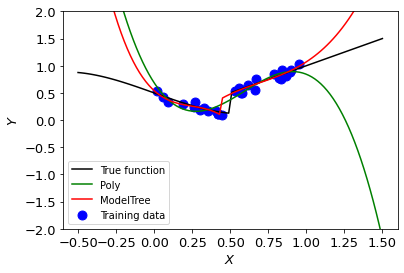

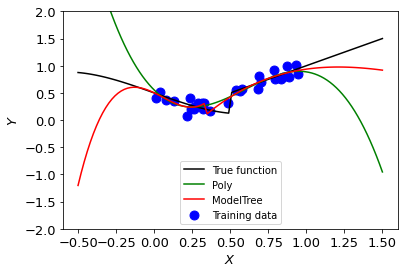

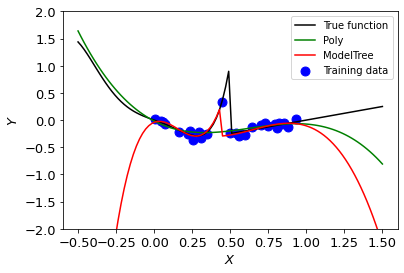

In [101]:
for f in [f_orig, f_noisy, f_step]:
    X, y = sample(30, f, [0,1])
    X = np.reshape(X, (X.shape[0], 1))
    y = np.reshape(y, (y.shape[0], 1))

    poly = Poly(3)

    model = PolyTree()
    model_tree = ModelTree(model, max_depth=2, min_samples_leaf=10,
                           search_type="greedy", n_search_grid=100)

    plot([poly, model_tree], f, X, y)